# CESNET Sampling and EDA

In [1]:
import pandas as pd
import numpy as np

### Load QUICaid Benign Data

In [2]:
quicaid_df = pd.read_csv('benign.csv')
quicaid_df.dropna(inplace=True)
quicaid_df

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,...,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
0,443,13335.0,1,1.616348,0,12.373573,3154.023657,20,5098.0,1250.0,...,0.244896,0.468212,0.219222,0.358289,0.358289,3.452879e-02,0.096112,0.094490,0.008928,0
1,443,13335.0,1,0.127682,1,234.958082,181967.202201,30,23234.0,1250.0,...,0.072812,0.034301,0.001177,0.127682,0.127682,4.894717e-02,0.096772,0.023456,0.000550,0
2,443,13335.0,1,0.725707,1,41.339020,28331.008390,30,20560.0,1250.0,...,0.256128,0.294598,0.086788,0.725707,0.725707,5.600000e-08,0.474463,0.311842,0.097245,0
3,443,13335.0,1,0.226025,0,132.728759,88105.349930,30,19914.0,1250.0,...,0.199391,0.011408,0.000130,0.226025,0.226025,5.700000e-08,0.052990,0.077739,0.006043,0
4,443,13335.0,1,0.172525,1,173.887621,157211.797788,30,27123.0,1200.0,...,0.077448,0.045418,0.002063,0.172525,0.172525,2.566661e-02,0.153548,0.045018,0.002027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190911,443,15169.0,1,29.998893,1,0.700026,278.976958,21,8369.0,1250.0,...,3.922603,9.856434,97.149289,0.531961,0.531961,1.595114e-01,0.270615,0.112888,0.012744,0
190912,443,15169.0,1,30.044550,1,0.698962,278.652863,21,8372.0,1250.0,...,3.929291,9.871166,97.439915,0.533189,0.533189,1.597567e-01,0.271673,0.113271,0.012830,0
190913,443,15169.0,1,18.291163,1,1.366780,598.048360,25,10939.0,1250.0,...,2.186556,5.694979,32.432791,0.533138,0.533138,1.598943e-01,0.250091,0.109835,0.012064,0
190914,443,9821.0,1,0.252247,1,118.930827,45344.360008,30,11438.0,1250.0,...,0.040288,0.069151,0.004782,0.251711,0.251711,3.179404e-03,0.051783,0.090803,0.008245,0


### Load CESNET Data

In [3]:
TARGET_AVG = 29.648434  # Change this to your desired average
MAX_ROWS = 200000

columns = pd.read_csv('cesnet_dataset.csv', nrows=0).columns
cesnet_df = pd.DataFrame(columns=list(columns))

total_sum = 0
total_count = 0

for chunk in pd.read_csv('cesnet_dataset.csv', chunksize=100000):
    lower_bound = max(1, TARGET_AVG - 1)  # Adjust bounds based on target
    upper_bound = 30

    filtered_chunk = chunk[
        (chunk['total_pkts'] >= lower_bound) & 
        (chunk['total_pkts'] <= upper_bound)
    ]

    # Update sum and count
    new_total_sum = total_sum + filtered_chunk['total_pkts'].sum()
    new_total_count = total_count + len(filtered_chunk)

    # Ensure we do not exceed 200k rows
    if new_total_count > MAX_ROWS:
        excess_rows = new_total_count - MAX_ROWS
        filtered_chunk = filtered_chunk.iloc[:-excess_rows]  # Trim extra rows
        new_total_sum -= filtered_chunk['total_pkts'][-excess_rows:].sum()
        new_total_count = MAX_ROWS
        
    cesnet_df = pd.concat([cesnet_df, filtered_chunk], ignore_index=True)
    total_sum, total_count = new_total_sum, new_total_count
    
    if total_count == MAX_ROWS:
        break

cesnet_df.dropna(inplace=True)
cesnet_df

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,...,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
0,443,15169,1,20.9293,1,1.433397,436.421667,30,9134,1250,...,1603.0,5524.672033,30522001.076923,2.048,21.0,0.0,5.6875,6.252187,39.089844,0
1,443,15169,1,0.112292,1,267.160617,175070.352296,30,19659,1250,...,4.923077,8.389201,70.378698,0.063,28.0,0.0,3.0625,6.731166,45.308594,0
2,443,15169,1,25.030716,0,1.198527,485.323712,30,12148,1250,...,1781.857143,6404.336331,41015523.836735,2.048,22.0,0.0,5.666667,7.67391,58.888889,0
3,443,13335,4278190109,0.02256,1,1329.787234,607402.48227,30,13703,1350,...,1.5,2.43242,5.916667,0.015,2.0,0.0,0.235294,0.545507,0.297578,0
4,443,15169,1,0.483767,0,59.946214,23081.359415,29,11166,1250,...,5.214286,9.570629,91.596939,0.255,110.0,0.0,29.357143,46.361325,2149.372449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,443,15169,1,0.255025,0,113.714342,58484.462308,29,14915,1250,...,13.071429,16.730914,279.923469,0.127,25.0,0.0,5.142857,6.791351,46.122449,0
199996,443,15169,1,11.064789,0,2.711303,1147.694728,30,12699,1250,...,732.066667,2710.299208,7345721.795556,2.048,34.0,0.0,6.0,9.312051,86.714286,0
199997,443,15169,1,4.479207,1,6.697614,2023.125969,30,9062,1250,...,357.5,1041.027897,1083739.083333,2.048,31.0,0.0,11.117647,9.975749,99.515571,0
199998,443,15169,1,0.081618,1,355.313779,240461.662868,29,19626,1250,...,4.818182,11.2235,125.966942,0.031,20.0,0.0,1.647059,4.739585,22.463668,0


In [ ]:
# cesnet_df.to_csv('reduced_cesnet.csv', index=None)

In [ ]:
# cesnet_df = pd.read_csv('reduced_cesnet.csv')
# cesnet_df.dropna(inplace=True)
# cesnet_df = cesnet_df.astype(float)

### EDA

In [4]:
quicaid_df.describe()

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,...,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
count,164720.0,164720.000000,164720.0,164720.000000,164720.000000,164720.000000,1.647200e+05,164720.000000,164720.00000,164720.000000,...,164720.000000,164720.000000,1.647200e+05,164720.000000,164720.000000,1.647200e+05,164720.000000,164720.000000,1.647200e+05,164720.0
mean,443.0,10635.469822,1.0,0.191815,0.983165,8343.844691,9.382983e+06,29.648434,31430.45312,1231.922608,...,0.058296,0.068861,9.316219e-01,0.023887,0.026503,2.875062e-03,0.014180,0.008290,2.924334e-03,0.0
std,0.0,2606.131492,0.0,2.476014,0.128652,10331.399018,1.256236e+07,2.620009,5650.01728,54.480498,...,0.773433,0.962749,3.627466e+01,0.810006,0.148583,3.088548e-02,0.073308,0.053438,4.202646e-01,0.0
min,443.0,2647.000000,1.0,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000e+00,-291.430036,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0
25%,443.0,9821.000000,1.0,0.003195,1.000000,4884.350784,5.174969e+06,30.000000,32168.00000,1232.000000,...,0.001573,0.000635,4.030150e-07,0.003106,0.003106,7.900000e-08,0.001571,0.000906,8.210242e-07,0.0
50%,443.0,9821.000000,1.0,0.004118,1.000000,7285.065967,8.005469e+06,30.000000,33366.00000,1232.000000,...,0.002209,0.001071,1.147559e-06,0.004001,0.004001,3.710000e-07,0.002093,0.001189,1.414266e-06,0.0
75%,443.0,9821.000000,1.0,0.006141,1.000000,9388.692087,1.050622e+07,30.000000,33849.00000,1232.000000,...,0.003292,0.001655,2.738531e-06,0.005870,0.005870,3.296725e-04,0.003100,0.001741,3.030806e-06,0.0
max,443.0,393257.000000,1.0,244.574663,1.000000,461013.615274,4.769954e+08,30.000000,37500.00000,1250.000000,...,77.432800,75.943787,5.767459e+03,30.004793,30.004793,6.503636e+00,7.519459,12.981937,1.685307e+02,0.0


In [5]:
cesnet_df.astype(float).describe()

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,...,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
count,200000.0,200000.00000,2.000000e+05,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,2.000000e+05,200000.0
mean,443.0,17570.43778,2.504974e+08,5.281151,0.385710,117.664485,5.597690e+04,29.500640,13062.699585,1260.261895,...,366.068796,1004.448572,6.860910e+06,0.717125,338.911930,0.00449,34.425579,88.419773,5.687592e+05,0.0
std,0.0,6889.77879,9.978675e+08,14.369047,0.486764,141.042961,7.671508e+04,0.500001,3596.501413,36.525996,...,1178.729511,2419.095337,2.914557e+07,0.847976,2837.950633,0.24450,264.919546,748.961895,1.001204e+07,0.0
min,443.0,174.00000,1.000000e+00,0.006458,0.000000,0.082651,1.785834e+01,29.000000,4354.000000,1200.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.00000,0.000000,0.000000,0.000000e+00,0.0
25%,443.0,15169.00000,1.000000e+00,0.172091,0.000000,10.435559,4.078390e+03,29.000000,10883.000000,1250.000000,...,5.250000,7.728015,5.972222e+01,0.063000,22.000000,0.00000,4.400000,6.707873,4.499556e+01,0.0
50%,443.0,15169.00000,1.000000e+00,0.360177,0.000000,81.879848,3.686274e+04,30.000000,12971.000000,1250.000000,...,13.692308,24.189478,5.851309e+02,0.255000,32.000000,0.00000,7.000000,10.168361,1.033956e+02,0.0
75%,443.0,15169.00000,1.000000e+00,2.834481,1.000000,171.267260,7.847009e+04,30.000000,14908.000000,1252.000000,...,158.924451,450.304191,2.027739e+05,2.048000,81.000000,0.00000,12.750000,22.449647,5.039867e+02,0.0
max,443.0,61098.00000,4.278190e+09,350.872560,1.000000,4490.554351,2.204552e+06,30.000000,40002.000000,1472.000000,...,32089.000000,32089.000000,1.029704e+09,2.048000,64996.000000,25.00000,11038.375000,19866.007516,3.946583e+08,0.0


In [ ]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import ks_2samp, chi2_contingency
# from scipy.spatial.distance import jensenshannon

# # Load datasets
# df1 = pd.read_csv("benign.csv")  # Simulated dataset
# df1.dropna(inplace=True)
# df2 = pd.read_csv("reduced_cesnet.csv")  # External dataset
# df2.dropna(inplace=True)

# # 1. Check for feature compatibility
# common_cols = list(set(df1.columns) & set(df2.columns))
# df1, df2 = df1[common_cols], df2[common_cols]

# print("Common columns:", common_cols)

# # 2. Compare summary statistics
# print("\nDataset 1 summary:")
# print(df1.describe())

# print("\nDataset 2 summary:")
# print(df2.describe())

# # 3. Compare distributions
# for col in common_cols:
#     if df1[col].dtype in ['float64', 'int64']:
#         plt.figure(figsize=(8, 4))
#         sns.kdeplot(df1[col], label='Dataset 1', shade=True)
#         sns.kdeplot(df2[col], label='Dataset 2', shade=True)
#         plt.title(f"Distribution of {col}")
#         plt.legend()
#         plt.show()
        
#         # KS Test
#         ks_stat, ks_p = ks_2samp(df1[col].dropna(), df2[col].dropna())
#         print(f"{col} - KS Test: Stat={ks_stat:.3f}, P-Value={ks_p:.3f}")
    
#     elif df1[col].dtype == 'object':  # Categorical
#         contingency_table = pd.crosstab(df1[col], df2[col])
#         chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)
#         print(f"{col} - Chi-Square Test: Stat={chi2_stat:.3f}, P-Value={chi2_p:.3f}")

# # 4. Check for duplicates
# overlap = df1.merge(df2, how='inner')
# print("\nNumber of overlapping rows:", len(overlap))

# # 5. Measure Jensen-Shannon Divergence
# js_divergences = {}
# for col in common_cols:
#     if df1[col].dtype in ['float64', 'int64']:
#         hist1, _ = np.histogram(df1[col].dropna(), bins=50, density=True)
#         hist2, _ = np.histogram(df2[col].dropna(), bins=50, density=True)
#         js_div = jensenshannon(hist1, hist2)
#         js_divergences[col] = js_div
#         print(f"{col} - JS Divergence: {js_div:.3f}")

# # If JS Divergence is low (e.g., < 0.1), datasets are similar

Common columns: ['var_fwd_iat', 'ave_rev_iat', 'fwd_pkts', 'ave_fwd_bytes', 'std_fwd_bytes', 'ave_fwd_iat', 'max_rev_bytes', 'dur', 'var_iat', 'total_pkts', 'ratio', 'fwd_bytes', 'min_fwd_bytes', 'min_bytes', 'dst_asn', 'min_iat', 'ave_iat', 'var_bytes', 'std_rev_bytes', 'total_bytes', 'rev_bytes', 'fwd_dur', 'max_fwd_iat', 'ave_bytes', 'std_rev_iat', 'max_fwd_bytes', 'var_rev_bytes', 'std_fwd_iat', 'label', 'var_rev_iat', 'rev_pkts', 'var_fwd_bytes', 'rev_dur', 'ave_rev_bytes', 'max_bytes', 'max_rev_iat', 'quic_ver', 'dst_port', 'std_iat', 'min_rev_iat', 'min_rev_bytes', 'std_bytes', 'max_iat', 'min_fwd_iat', 'flow_pkt_rate', 'flow_byte_rate']

Dataset 1 summary:
        var_fwd_iat    ave_rev_iat       fwd_pkts  ave_fwd_bytes  \
count  1.647200e+05  164720.000000  164720.000000  164720.000000   
mean   9.316219e-01       0.014180       3.706745      59.595099   
std    3.627466e+01       0.073308       2.507264      93.183972   
min    0.000000e+00       0.000000       0.000000      

C:\Users\Carlo Alamani\AppData\Local\Temp\ipykernel_17384\500448432.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
C:\Users\Carlo Alamani\AppData\Local\Temp\ipykernel_17384\500448432.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2[col], label='Dataset 2', shade=True, ax=axes[i])
C:\Users\Carlo Alamani\AppData\Local\Temp\ipykernel_17384\500448432.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
C:\Users\Carlo Alamani\AppData\Local\Temp\ipykernel_17384\500448432.py:40: FutureWarning: 

`shade` is now

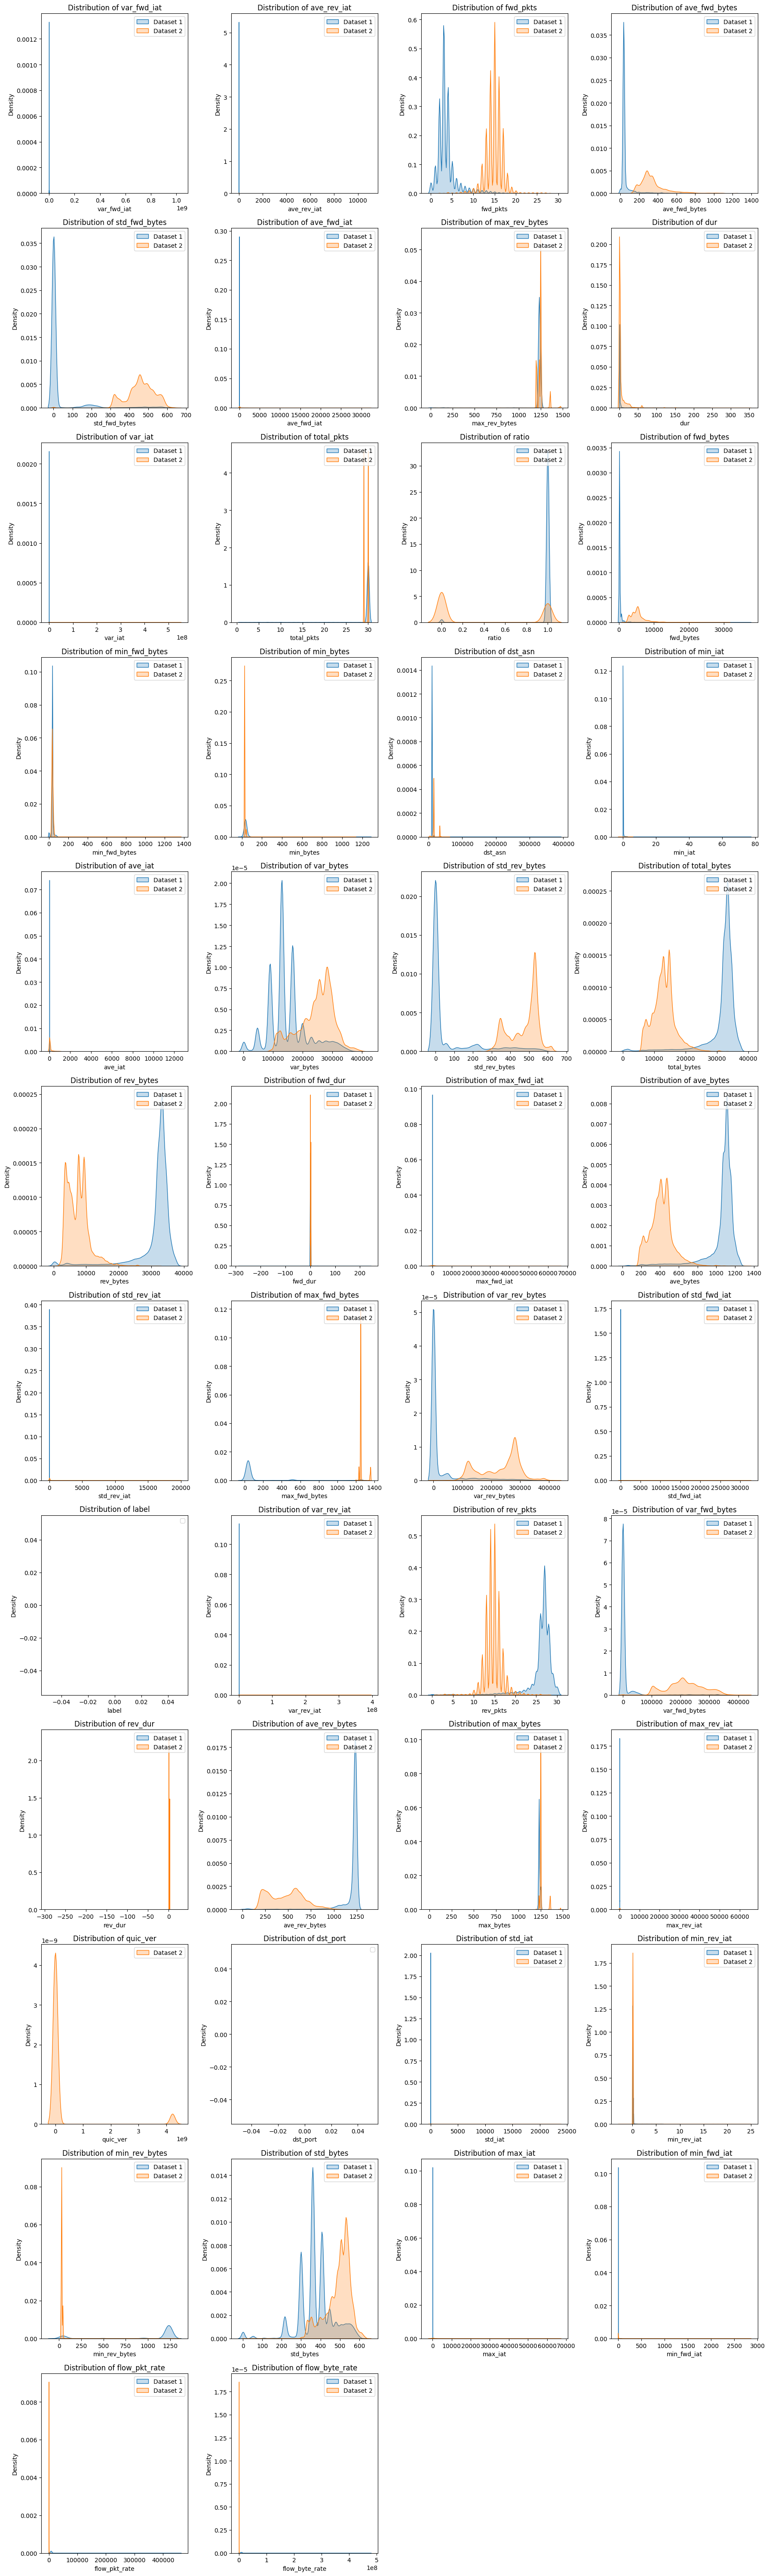

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon

# Load datasets
df1 = quicaid_df  # Simulated dataset
df2 = cesnet_df  # External dataset

# 1. Check for feature compatibility
common_cols = list(set(df1.columns) & set(df2.columns))
df1, df2 = df1[common_cols], df2[common_cols]

print("Common columns:", common_cols)

# 2. Compare summary statistics
print("\nDataset 1 summary:")
print(df1.describe())

print("\nDataset 2 summary:")
print(df2.describe())

# 3. Single Large Plot for Distribution Comparison (only when both datasets have data)
num_features = [
    col for col in common_cols 
    if df1[col].dtype in ['float64', 'int64'] and df1[col].dropna().size > 0 and df2[col].dropna().size > 0
]
num_plots = len(num_features)

if num_plots > 0:
    # Set up the figure with subplots
    rows = (num_plots // 4) + (num_plots % 4 > 0)  # Arrange in rows of 3 columns
    fig, axes = plt.subplots(rows, 4, figsize=(18, rows * 5))  # Adjust figure size dynamically
    axes = axes.flatten()  # Flatten to easily iterate

    for i, col in enumerate(num_features):
        sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
        sns.kdeplot(df2[col], label='Dataset 2', shade=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].legend()

    # Hide unused subplots if any
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
else:
    print("No features have valid data in both datasets for comparison.")
